# Inference on simulated CHARA data on a "Gaussian blob" star 

In this notebook, I show how to infer the radius of a "Gaussian blob" star with simulated squared visibility data from a CHARA-PAVO-like instrument. I will use jax for the model and numpyro for the sampling. 

A star modeled by a Gaussian makes a good initial foray into interferometric data modeling; because the Fourier tranform of a Gaussian is also a Gaussian, our $V^2$ is also expected to be a Gaussian with respect to baseline. With time, I expect to extend this inference to other analytic models such as a uniform disk, and eventually to numerical models such as the ELR model shown in the other notebooks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#this is the way I've found to get jax to use multiple CPU cores on Apple Silicon
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"

import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer

import arviz as az

import corner

## Creating (an approximation) of the CHARA array:

The CHARA array has a Y-shaped baseline. I assume for simplicity that the angle between each arm is exactly 120 degrees and that we have 3 telescopes per arm. 

NOTE: CHARA only has 2 telescopes per arm. Because I am not yet taking into account effects like chromaticity and the projected baseline changing as the star moves across the sky, I am adding an extra baseline in each arm to better sample the visibilities.

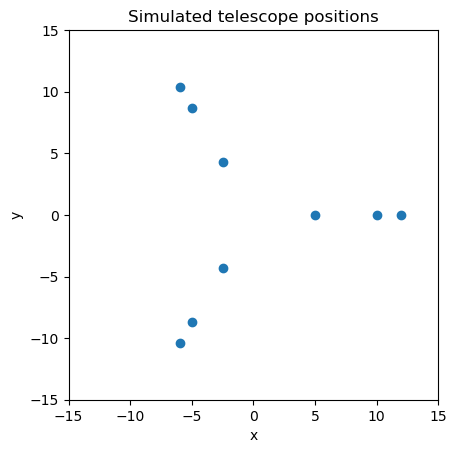

In [2]:
thetas = jnp.array([0,0,0,120,120,120,240,240,240])
radii = jnp.array([5,10,12,5,10,12,5,10,12])

station_x = radii * jnp.cos(thetas*jnp.pi/180)
station_y = radii * jnp.sin(thetas*jnp.pi/180)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Simulated telescope positions")
plt.scatter(station_x, station_y)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.gca().set_aspect('equal', adjustable='box')

Doing the autocorrelation of the above plot to get the baselines:

In [3]:
baselines_x = []
baselines_y = []
for i, sxi in enumerate(station_x):
    for j, sxj in enumerate(station_x):
        syi = station_y[i]
        syj = station_y[j]
        
        if i == j:
            continue
            
        baselines_x.append(sxj-sxi)
        baselines_y.append(syj-syi)
baselines_x = jnp.array(baselines_x)
baselines_y = jnp.array(baselines_y)

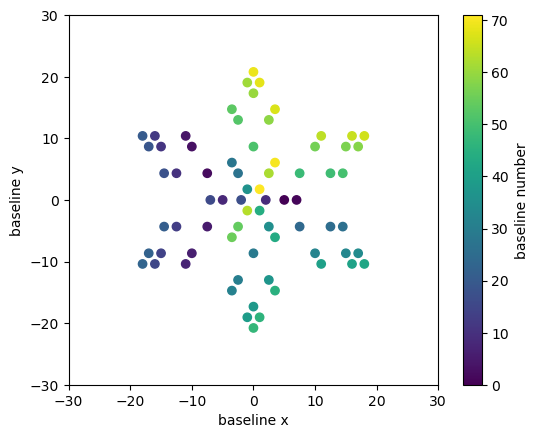

In [4]:
plt.scatter(baselines_x,baselines_y,c=np.arange(len(baselines_x)))
plt.xlabel("baseline x")
plt.ylabel("baseline y")
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar()
cbar.set_label('baseline number')

### Sidetrack: neat vectorized way of autocorrelating the baselines in numpy (might be useful for AMI?):

In [5]:
outer_blx = np.subtract.outer(station_x,station_x)
outer_blx = outer_blx.T[np.where(~np.eye(outer_blx.shape[0],dtype=bool))]
outer_bly = np.subtract.outer(station_y,station_y)
outer_bly = outer_bly.T[np.where(~np.eye(outer_bly.shape[0],dtype=bool))]

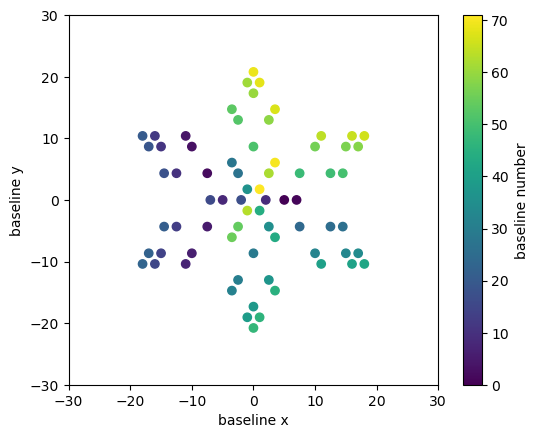

In [6]:
plt.scatter(outer_blx,outer_bly,c=np.arange(len(outer_blx)))
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("baseline x")
plt.ylabel("baseline y")

cbar = plt.colorbar()
cbar.set_label('baseline number')

## Inference on a single blob star:

In [7]:
#getting the U and V planes
u = np.subtract.outer(station_x,station_x)
u = u.T[np.where(~np.eye(u.shape[0],dtype=bool))]
v = np.subtract.outer(station_y,station_y)
v = v.T[np.where(~np.eye(v.shape[0],dtype=bool))]

### Plotting the simulated dataset with gaussian scatter alongside the truth

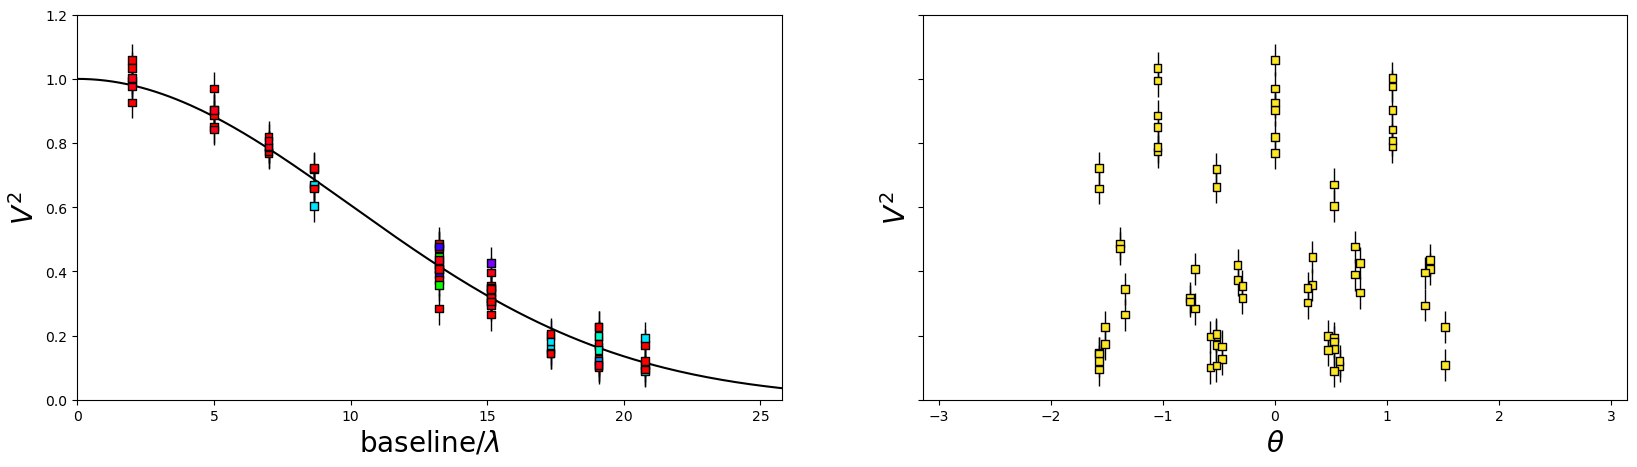

In [8]:
x = jnp.hypot(u,v)
theta = jnp.arctan(v/u)

#parameters of the Gaussian
true_params = [10]


# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(11)

yerr = 0.05 * np.ones_like(x)

#gaussian
y = np.exp(-((x)**2)/(2*true_params[0]**2)) + yerr * np.random.randn(len(x))


# Then save the *true* line.
x0 = np.linspace(0, jnp.max(x)+5.0, 200)
y0 = np.exp(-((x0)**2)/(2*true_params[0]**2))

cmap = plt.get_cmap("hsv")
cmap2 = plt.get_cmap("viridis")



def plot_data():
    fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
    ax[0].errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[0].scatter(x, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap(theta))
    ax[0].plot(x0, y0, color="k", lw=1.5)
    ax[0].set_xlabel("baseline/$\lambda$", fontsize=20)
    ax[0].set_ylabel("$V^2$", fontsize=20)
    ax[0].set_ylim(0, 1.2)
    ax[0].set_xlim(0, jnp.max(x0))
    
    ax[1].errorbar(theta, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[1].scatter(theta, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap2(x))
    ax[1].set_xlabel(r"$\theta$", fontsize=20)
    ax[1].set_ylabel("$V^2$", fontsize=20)
    ax[1].set_ylim(0, 1.2)
    ax[1].set_xlim(-np.pi, np.pi)


plot_data()

### The jax gaussian model:

Here I code up the (trivial) jax model for a Gaussian, where the only free parameter is sigma, the width (corresponds inversely to the stellar apparent radius).

I also code the numpyro model, which samples and performs inference given the model and a set of baselines

In [9]:
import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer

numpyro.set_host_device_count(2)

def gaussian_model(u,v,sigma):
    x = jnp.hypot(u,v)
    theta = jnp.arctan(v/u)
    
    return jnp.exp(-((x)**2)/(2*sigma**2))

def model(u,v, yerr, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    sigma = numpyro.sample("sigma", dist.Uniform(0, 20))


    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with numpyro.plate("data", len(u)):
        numpyro.sample("y", dist.Normal(gaussian_model(u,v,sigma), yerr), obs=y)

In [10]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), u, v, yerr, y=y)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 1.34 s, sys: 54.1 ms, total: 1.39 s
Wall time: 1.37 s


In [12]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,9.961,0.098,9.785,10.153,0.003,0.002,1437.0,2282.0,1.0


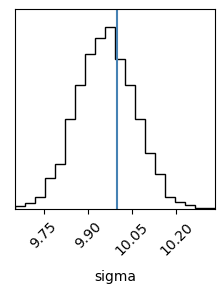

In [13]:
corner.corner(inf_data, var_names=["sigma"], truths=true_params);

## Inference on an ensemble of Gaussian stars:


Next, I create a set of stars, each with their own radii and gaussian noise, and attempt to infer their radii within the same model. This may seem like a trivial addition to the previous example of a single star, but it will be crucial for the next step--(hierarchical) systematics inference on an ensemble of stars.

In [21]:
np.random.seed(40)
num_stars = 5
sigmas = np.random.uniform(5,20,num_stars)
#parameters of the Gaussian

# For reproducibility, let's set the random number seed and generate the data:

yerr = 0.05

#gaussian
y = np.exp(-((x)**2)/(2*sigmas[np.newaxis,:].T**2)) + yerr * np.random.randn(num_stars,x.shape[0])


# Then save the *true* line.
x0 = np.linspace(0, jnp.max(x)+5.0, 200)
y0 = np.exp(-((x0)**2)/(2*sigmas[np.newaxis,:].T**2))

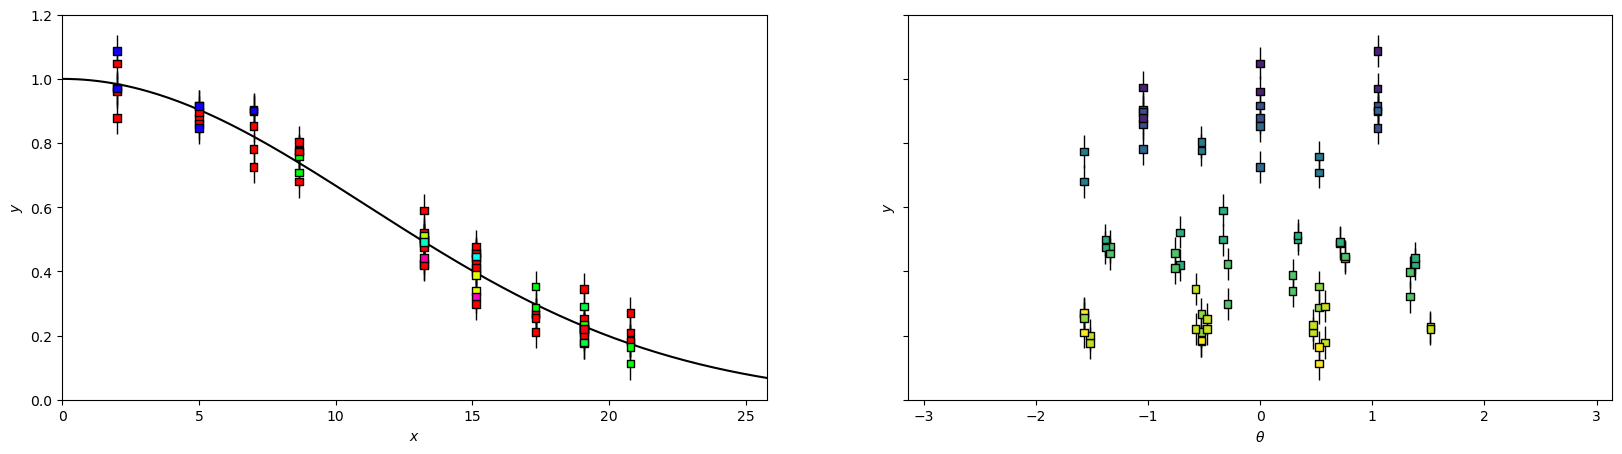

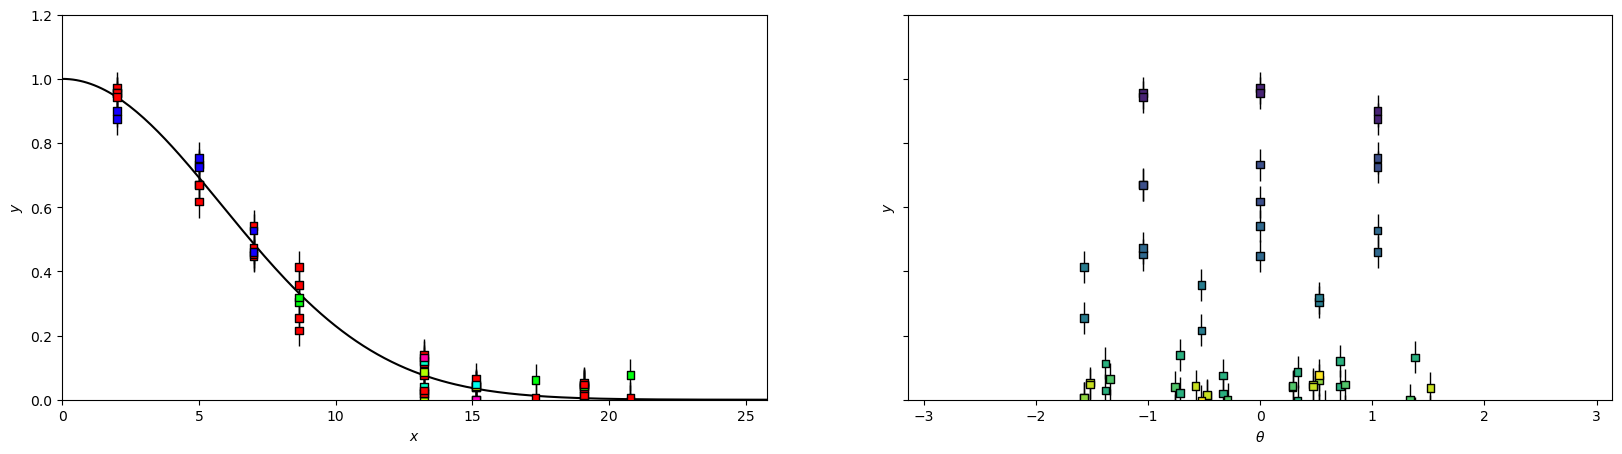

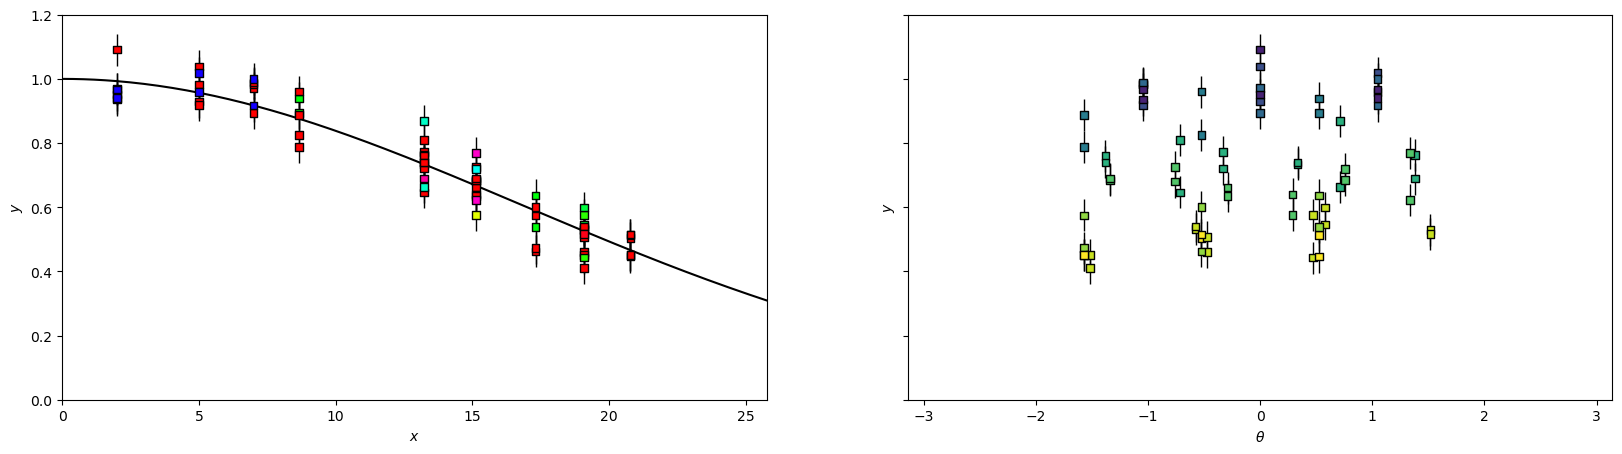

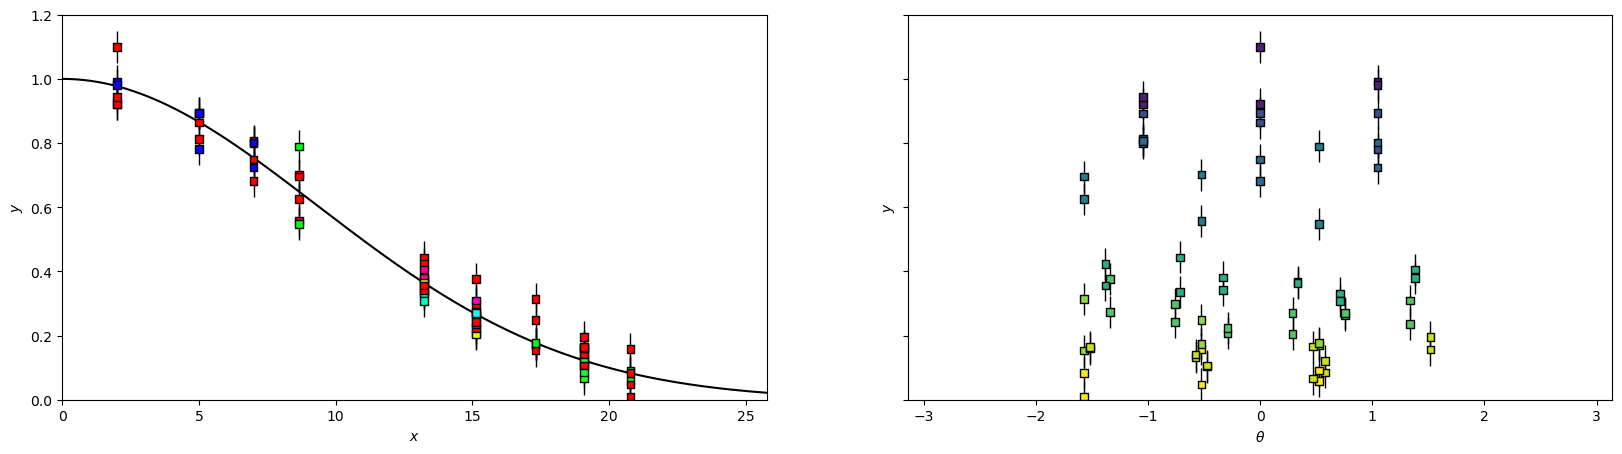

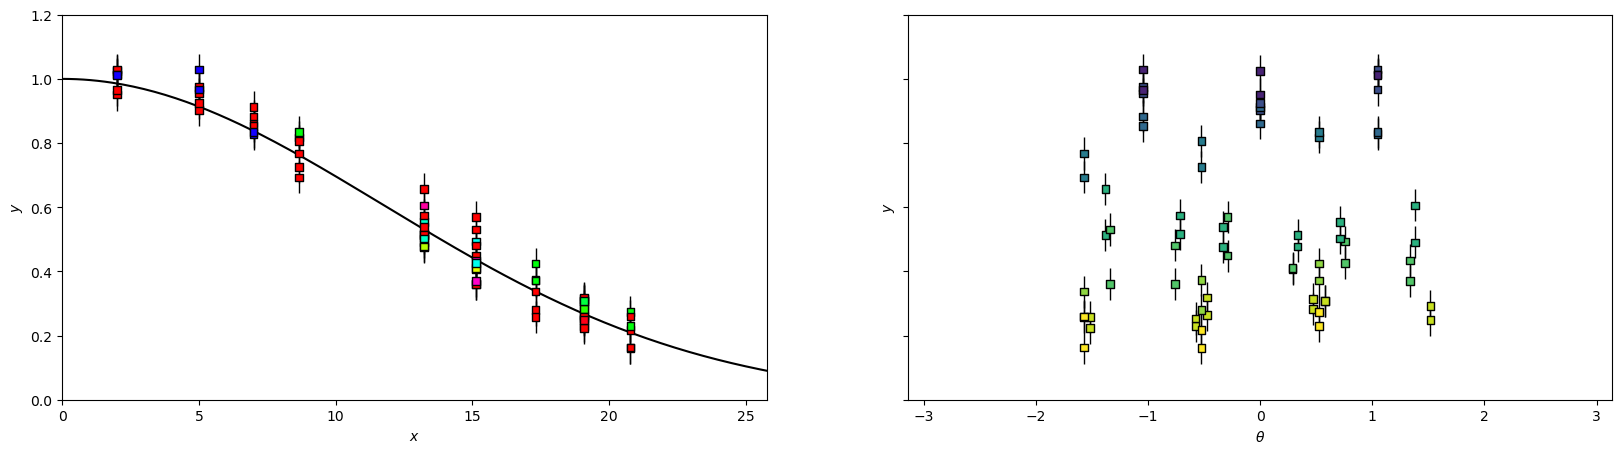

In [22]:
def plot_data(x, y, x0, y0, yerr):
    fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
    
    ax[0].errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[0].scatter(x, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap(theta/theta.max()))
    ax[0].plot(x0, y0, color="k", lw=1.5)
    ax[0].set_xlabel("$x$")
    ax[0].set_ylabel("$y$")
    ax[0].set_ylim(0, 1.2)
    ax[0].set_xlim(0, jnp.max(x0))
    
    ax[1].errorbar(theta, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[1].scatter(theta, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap2(x/x.max()))
    ax[1].set_xlabel(r"$\theta$")
    ax[1].set_ylabel("$y$")
    ax[1].set_ylim(0, 1.2)
    ax[1].set_xlim(-np.pi, np.pi)
    
for i, sigma in enumerate(sigmas):
    plot_data(x,y[i], x0, y0[i], yerr)

In [27]:
def model_multi(u,v, yerr, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.


    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with numpyro.plate("stars", y.shape[0],dim=-2):
        sigma = numpyro.sample("sigma", dist.Uniform(0, 20))
        
    with numpyro.plate("data",y.shape[1]):
        numpyro.sample("y", dist.Normal(gaussian_model(u,v,sigma), yerr), obs=y)

In [28]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(model_multi),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), u, v, yerr, y=y)

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/jax/linear_util.py:167: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 1.4 s, sys: 36.2 ms, total: 1.44 s
Wall time: 1.38 s


In [29]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"sigma[0, 0]",11.144,0.113,10.947,11.368,0.002,0.001,4968.0,3116.0,1.0
"sigma[1, 0]",5.683,0.086,5.520,5.844,0.001,0.001,5246.0,3213.0,1.0
"sigma[2, 0]",16.742,0.200,16.370,17.115,0.003,0.002,5505.0,3071.0,1.0
"sigma[3, 0]",9.391,0.097,9.216,9.590,0.001,0.001,4660.0,2956.0,1.0
"sigma[4, 0]",11.892,0.119,11.669,12.111,0.002,0.001,5304.0,3123.0,1.0


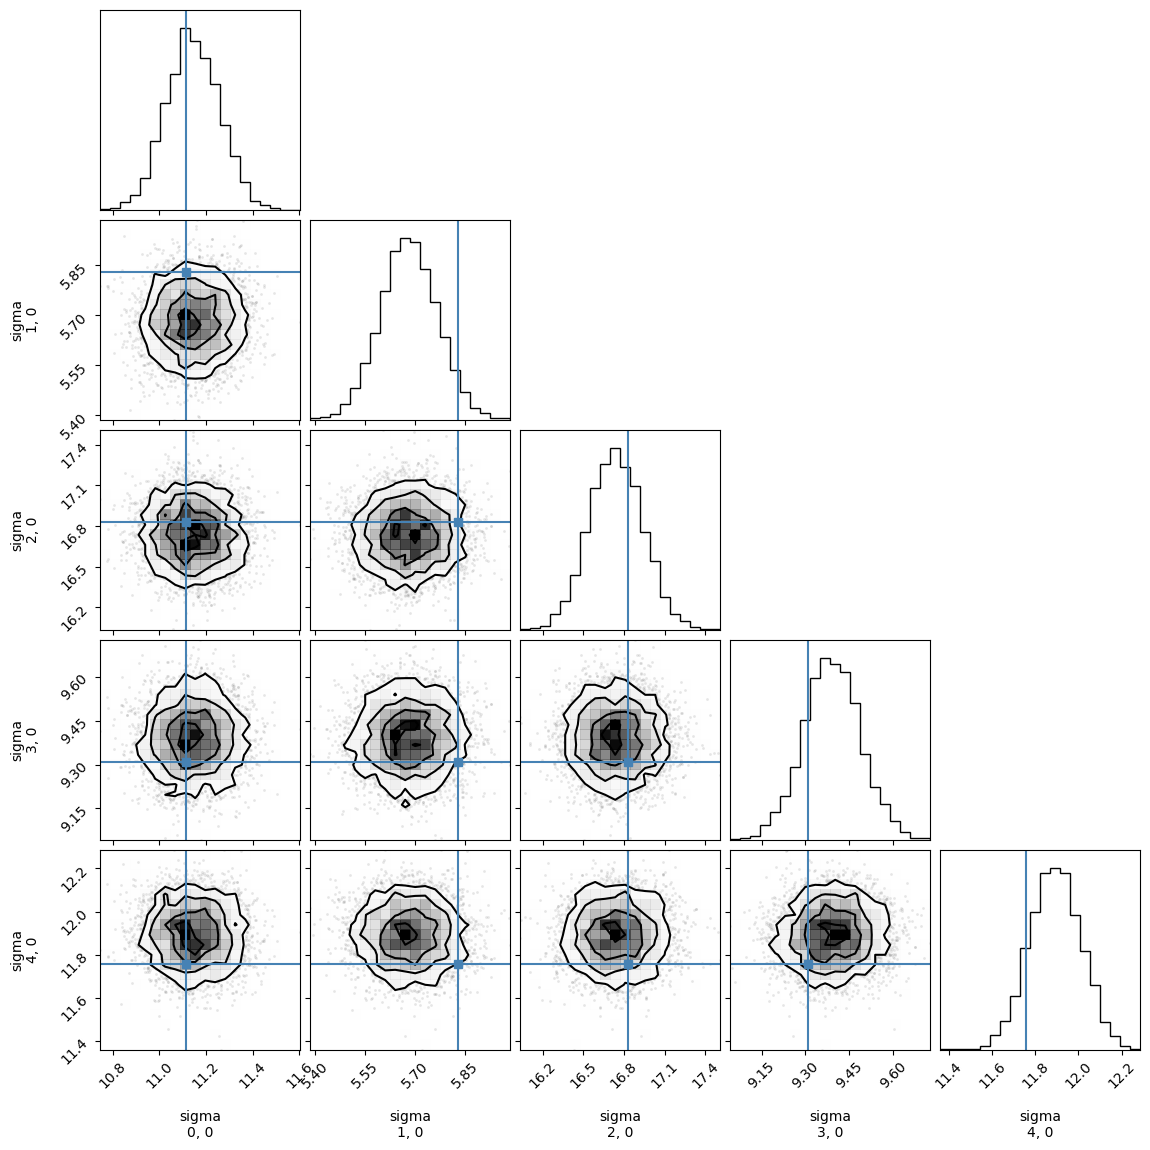

In [30]:
corner.corner(inf_data, var_names=["sigma"], truths=sigmas);

As we can see, we recover the radii of these stars quite well!